In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import itertools
import time

from torch.utils.data import DataLoader
from torch import nn
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

sys.path.append("..")
from utils import metrics
from utils.data import TimeFusionDataset
from timefusion import TimeFusion
from utils.early_stopper import EarlyStopper

In [2]:
# Import dataset
train_data = pd.read_csv("../../datasets/electricity/train.csv", index_col="date")
val_data = pd.read_csv("../../datasets/electricity/val.csv", index_col="date")
test_data = pd.read_csv("../../datasets/electricity/test.csv", index_col="date")

# Normalize the signal power of each column
stds = train_data.std()
train_data /= stds
val_data /= stds
test_data /= stds

# Concatenate to get the full data
full_data = pd.concat([train_data,val_data,test_data])

In [3]:
# Compute device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [4]:
context_length = 24
prediction_length = 24

 # Function to create datasets and dataloaders
def get_data_loader(data, context_length):

    dataset = TimeFusionDataset(
        data = data,
        context_length = context_length,
    )
    dataset.add_timestamp_encodings()

    dataloader = DataLoader(
        dataset = dataset,
        shuffle = True,
        num_workers = 3,
        batch_size = 128,
    )

    return dataloader, dataset


In [5]:
# Create datasets and loaders
train_loader, train_dataset = get_data_loader(train_data, context_length)
val_loader, val_dataset = get_data_loader(val_data, context_length)
test_loader, test_dataset = get_data_loader(test_data, context_length)


In [6]:
rnn_hidden = int(0.333*train_data.shape[1])
residual_hidden = int((rnn_hidden + train_data.shape[1])*1)

predictor = TimeFusion(
    input_size = train_dataset.data.shape[1],
    output_size = train_data.shape[1],
    rnn_layers = 3,
    rnn_hidden = rnn_hidden,
    residual_layers = 8,
    residual_hidden = residual_hidden,
    dropout = 0,
    scaling = True,
    device = device,
    residual_scaler = False,
)

print("Number of trainable parameters:",sum(p.numel() for p in predictor.parameters()))

/rds/general/user/ejh19/home/Final-Year-Project/timefusion/examples/../utils/diffusion.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bar_alphas = torch.tensor(


Number of trainable parameters: 3594496


In [12]:
#predictor.load_state_dict(torch.load("weights/2023-06-11-14-55-51"))
#predictor.eval()

In [8]:
optimizer = torch.optim.Adam(params=predictor.parameters(), lr=1e-3, weight_decay=0)
lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.001, total_iters=200)

predictor.train_network(
    train_loader = train_loader,
    epochs=200,
    val_loader = val_loader,
    optimizer = optimizer,
    lr_scheduler= lr_scheduler,
    early_stopper=EarlyStopper(patience=200),
    disable_progress_bar = False,
    save_weights = True,
    weight_folder = "weights/electricity"
)

Epoch: 1/200: 100%|██████████| 160/160 [00:05<00:00, 29.33batch/s, Training loss=0.6750]


val_loss: 0.5082 , 


Epoch: 2/200: 100%|██████████| 160/160 [00:05<00:00, 28.10batch/s, Training loss=0.4321]


val_loss: 0.3730 , 


Epoch: 3/200: 100%|██████████| 160/160 [00:05<00:00, 28.53batch/s, Training loss=0.3282]


val_loss: 0.2992 , 


Epoch: 4/200: 100%|██████████| 160/160 [00:05<00:00, 28.99batch/s, Training loss=0.2671]


val_loss: 0.2592 , 


Epoch: 5/200: 100%|██████████| 160/160 [00:05<00:00, 29.80batch/s, Training loss=0.2382]


val_loss: 0.2306 , 


Epoch: 6/200: 100%|██████████| 160/160 [00:05<00:00, 30.30batch/s, Training loss=0.2207]


val_loss: 0.2272 , 


Epoch: 7/200: 100%|██████████| 160/160 [00:05<00:00, 30.51batch/s, Training loss=0.2060]


val_loss: 0.2103 , 


Epoch: 8/200: 100%|██████████| 160/160 [00:05<00:00, 30.21batch/s, Training loss=0.1975]


val_loss: 0.2012 , 


Epoch: 9/200: 100%|██████████| 160/160 [00:05<00:00, 30.52batch/s, Training loss=0.1864]


val_loss: 0.1950 , 


Epoch: 10/200: 100%|██████████| 160/160 [00:05<00:00, 30.48batch/s, Training loss=0.1787]


val_loss: 0.1885 , 


Epoch: 11/200: 100%|██████████| 160/160 [00:05<00:00, 30.41batch/s, Training loss=0.1689]


val_loss: 0.1813 , 


Epoch: 12/200: 100%|██████████| 160/160 [00:05<00:00, 28.64batch/s, Training loss=0.1635]


val_loss: 0.1704 , 


Epoch: 13/200: 100%|██████████| 160/160 [00:05<00:00, 29.67batch/s, Training loss=0.1614]


val_loss: 0.1647 , 


Epoch: 14/200: 100%|██████████| 160/160 [00:05<00:00, 29.94batch/s, Training loss=0.1570]


val_loss: 0.1630 , 


Epoch: 15/200: 100%|██████████| 160/160 [00:06<00:00, 25.82batch/s, Training loss=0.1510]


val_loss: 0.1633 , 


Epoch: 16/200: 100%|██████████| 160/160 [00:05<00:00, 27.38batch/s, Training loss=0.1521]


val_loss: 0.1519 , 


Epoch: 17/200: 100%|██████████| 160/160 [00:05<00:00, 27.96batch/s, Training loss=0.1494]


val_loss: 0.1594 , 


Epoch: 18/200: 100%|██████████| 160/160 [00:05<00:00, 27.95batch/s, Training loss=0.1482]


val_loss: 0.1544 , 


Epoch: 19/200: 100%|██████████| 160/160 [00:05<00:00, 28.00batch/s, Training loss=0.1447]


val_loss: 0.1562 , 


Epoch: 20/200: 100%|██████████| 160/160 [00:05<00:00, 29.07batch/s, Training loss=0.1407]


val_loss: 0.1481 , 


Epoch: 21/200: 100%|██████████| 160/160 [00:05<00:00, 28.90batch/s, Training loss=0.1424]


val_loss: 0.1511 , 


Epoch: 22/200: 100%|██████████| 160/160 [00:05<00:00, 29.73batch/s, Training loss=0.1399]


val_loss: 0.1556 , 


Epoch: 23/200: 100%|██████████| 160/160 [00:05<00:00, 27.72batch/s, Training loss=0.1401]


val_loss: 0.1515 , 


Epoch: 24/200: 100%|██████████| 160/160 [00:05<00:00, 29.00batch/s, Training loss=0.1373]


val_loss: 0.1527 , 


Epoch: 25/200: 100%|██████████| 160/160 [00:05<00:00, 27.64batch/s, Training loss=0.1337]


val_loss: 0.1468 , 


Epoch: 26/200: 100%|██████████| 160/160 [00:06<00:00, 26.39batch/s, Training loss=0.1348]


val_loss: 0.1429 , 


Epoch: 27/200: 100%|██████████| 160/160 [00:06<00:00, 25.00batch/s, Training loss=0.1319]


val_loss: 0.1414 , 


Epoch: 28/200: 100%|██████████| 160/160 [00:05<00:00, 26.72batch/s, Training loss=0.1315]


val_loss: 0.1470 , 


Epoch: 29/200: 100%|██████████| 160/160 [00:06<00:00, 25.41batch/s, Training loss=0.1317]


val_loss: 0.1435 , 


Epoch: 30/200: 100%|██████████| 160/160 [00:05<00:00, 27.48batch/s, Training loss=0.1306]


val_loss: 0.1402 , 


Epoch: 31/200: 100%|██████████| 160/160 [00:06<00:00, 25.18batch/s, Training loss=0.1322]


val_loss: 0.1329 , 


Epoch: 32/200: 100%|██████████| 160/160 [00:06<00:00, 26.17batch/s, Training loss=0.1289]


val_loss: 0.1332 , 


Epoch: 33/200: 100%|██████████| 160/160 [00:06<00:00, 25.07batch/s, Training loss=0.1324]


val_loss: 0.1347 , 


Epoch: 34/200: 100%|██████████| 160/160 [00:05<00:00, 26.70batch/s, Training loss=0.1283]


val_loss: 0.1464 , 


Epoch: 35/200: 100%|██████████| 160/160 [00:06<00:00, 24.77batch/s, Training loss=0.1277]


val_loss: 0.1326 , 


Epoch: 36/200: 100%|██████████| 160/160 [00:05<00:00, 26.71batch/s, Training loss=0.1264]


val_loss: 0.1397 , 


Epoch: 37/200: 100%|██████████| 160/160 [00:06<00:00, 26.65batch/s, Training loss=0.1271]


val_loss: 0.1394 , 


Epoch: 38/200: 100%|██████████| 160/160 [00:06<00:00, 24.77batch/s, Training loss=0.1246]


val_loss: 0.1426 , 


Epoch: 39/200: 100%|██████████| 160/160 [00:05<00:00, 26.72batch/s, Training loss=0.1232]


val_loss: 0.1400 , 


Epoch: 40/200: 100%|██████████| 160/160 [00:06<00:00, 25.17batch/s, Training loss=0.1217]


val_loss: 0.1440 , 


Epoch: 41/200: 100%|██████████| 160/160 [00:06<00:00, 24.99batch/s, Training loss=0.1229]


val_loss: 0.1377 , 


Epoch: 42/200: 100%|██████████| 160/160 [00:06<00:00, 24.89batch/s, Training loss=0.1195]


val_loss: 0.1325 , 


Epoch: 43/200: 100%|██████████| 160/160 [00:06<00:00, 26.42batch/s, Training loss=0.1205]


val_loss: 0.1382 , 


Epoch: 44/200: 100%|██████████| 160/160 [00:06<00:00, 26.10batch/s, Training loss=0.1225]


val_loss: 0.1254 , 


Epoch: 45/200: 100%|██████████| 160/160 [00:06<00:00, 26.44batch/s, Training loss=0.1218]


val_loss: 0.1288 , 


Epoch: 46/200: 100%|██████████| 160/160 [00:06<00:00, 24.80batch/s, Training loss=0.1204]


val_loss: 0.1312 , 


Epoch: 47/200: 100%|██████████| 160/160 [00:05<00:00, 26.73batch/s, Training loss=0.1202]


val_loss: 0.1355 , 


Epoch: 48/200: 100%|██████████| 160/160 [00:06<00:00, 25.18batch/s, Training loss=0.1194]


val_loss: 0.1331 , 


Epoch: 49/200: 100%|██████████| 160/160 [00:05<00:00, 26.82batch/s, Training loss=0.1213]


val_loss: 0.1309 , 


Epoch: 50/200: 100%|██████████| 160/160 [00:06<00:00, 25.87batch/s, Training loss=0.1194]


val_loss: 0.1279 , 


Epoch: 51/200: 100%|██████████| 160/160 [00:06<00:00, 26.08batch/s, Training loss=0.1166]


val_loss: 0.1317 , 


Epoch: 52/200: 100%|██████████| 160/160 [00:06<00:00, 25.17batch/s, Training loss=0.1187]


val_loss: 0.1313 , 


Epoch: 53/200: 100%|██████████| 160/160 [00:06<00:00, 26.18batch/s, Training loss=0.1155]


val_loss: 0.1245 , 


Epoch: 54/200: 100%|██████████| 160/160 [00:06<00:00, 26.61batch/s, Training loss=0.1172]


val_loss: 0.1259 , 


Epoch: 55/200: 100%|██████████| 160/160 [00:06<00:00, 25.87batch/s, Training loss=0.1174]


val_loss: 0.1326 , 


Epoch: 56/200: 100%|██████████| 160/160 [00:05<00:00, 27.52batch/s, Training loss=0.1178]


val_loss: 0.1218 , 


Epoch: 57/200: 100%|██████████| 160/160 [00:06<00:00, 25.74batch/s, Training loss=0.1182]


val_loss: 0.1367 , 


Epoch: 58/200: 100%|██████████| 160/160 [00:05<00:00, 26.96batch/s, Training loss=0.1144]


val_loss: 0.1239 , 


Epoch: 59/200: 100%|██████████| 160/160 [00:06<00:00, 25.64batch/s, Training loss=0.1145]


val_loss: 0.1316 , 


Epoch: 60/200: 100%|██████████| 160/160 [00:06<00:00, 24.99batch/s, Training loss=0.1139]


val_loss: 0.1263 , 


Epoch: 61/200: 100%|██████████| 160/160 [00:06<00:00, 25.78batch/s, Training loss=0.1140]


val_loss: 0.1294 , 


Epoch: 62/200: 100%|██████████| 160/160 [00:06<00:00, 25.55batch/s, Training loss=0.1136]


val_loss: 0.1197 , 


Epoch: 63/200: 100%|██████████| 160/160 [00:06<00:00, 25.79batch/s, Training loss=0.1148]


val_loss: 0.1314 , 


Epoch: 64/200: 100%|██████████| 160/160 [00:05<00:00, 27.37batch/s, Training loss=0.1130]


val_loss: 0.1241 , 


Epoch: 65/200: 100%|██████████| 160/160 [00:05<00:00, 26.94batch/s, Training loss=0.1129]


val_loss: 0.1281 , 


Epoch: 66/200: 100%|██████████| 160/160 [00:06<00:00, 26.06batch/s, Training loss=0.1103]


val_loss: 0.1209 , 


Epoch: 67/200: 100%|██████████| 160/160 [00:06<00:00, 26.51batch/s, Training loss=0.1135]


val_loss: 0.1385 , 


Epoch: 68/200: 100%|██████████| 160/160 [00:06<00:00, 25.81batch/s, Training loss=0.1141]


val_loss: 0.1265 , 


Epoch: 69/200: 100%|██████████| 160/160 [00:05<00:00, 27.13batch/s, Training loss=0.1116]


val_loss: 0.1320 , 


Epoch: 70/200: 100%|██████████| 160/160 [00:06<00:00, 23.70batch/s, Training loss=0.1119]


val_loss: 0.1252 , 


Epoch: 71/200: 100%|██████████| 160/160 [00:06<00:00, 26.50batch/s, Training loss=0.1094]


val_loss: 0.1134 , 


Epoch: 72/200: 100%|██████████| 160/160 [00:06<00:00, 25.00batch/s, Training loss=0.1088]


val_loss: 0.1231 , 


Epoch: 73/200: 100%|██████████| 160/160 [00:06<00:00, 25.72batch/s, Training loss=0.1139]


val_loss: 0.1159 , 


Epoch: 74/200: 100%|██████████| 160/160 [00:06<00:00, 24.96batch/s, Training loss=0.1117]


val_loss: 0.1246 , 


Epoch: 75/200: 100%|██████████| 160/160 [00:06<00:00, 25.36batch/s, Training loss=0.1092]


val_loss: 0.1214 , 


Epoch: 76/200: 100%|██████████| 160/160 [00:06<00:00, 25.06batch/s, Training loss=0.1088]


val_loss: 0.1240 , 


Epoch: 77/200: 100%|██████████| 160/160 [00:05<00:00, 27.42batch/s, Training loss=0.1070]


val_loss: 0.1192 , 


Epoch: 78/200: 100%|██████████| 160/160 [00:06<00:00, 25.16batch/s, Training loss=0.1114]


val_loss: 0.1169 , 


Epoch: 79/200: 100%|██████████| 160/160 [00:06<00:00, 26.36batch/s, Training loss=0.1082]


val_loss: 0.1166 , 


Epoch: 80/200: 100%|██████████| 160/160 [00:06<00:00, 25.00batch/s, Training loss=0.1079]


val_loss: 0.1249 , 


Epoch: 81/200: 100%|██████████| 160/160 [00:05<00:00, 27.68batch/s, Training loss=0.1058]


val_loss: 0.1234 , 


Epoch: 82/200: 100%|██████████| 160/160 [00:06<00:00, 24.88batch/s, Training loss=0.1079]


val_loss: 0.1108 , 


Epoch: 83/200: 100%|██████████| 160/160 [00:05<00:00, 27.14batch/s, Training loss=0.1085]


val_loss: 0.1185 , 


Epoch: 84/200: 100%|██████████| 160/160 [00:06<00:00, 25.58batch/s, Training loss=0.1091]


val_loss: 0.1210 , 


Epoch: 85/200: 100%|██████████| 160/160 [00:05<00:00, 26.97batch/s, Training loss=0.1077]


val_loss: 0.1127 , 


Epoch: 86/200: 100%|██████████| 160/160 [00:05<00:00, 27.22batch/s, Training loss=0.1087]


val_loss: 0.1311 , 


Epoch: 87/200: 100%|██████████| 160/160 [00:06<00:00, 26.54batch/s, Training loss=0.1080]


val_loss: 0.1232 , 


Epoch: 88/200: 100%|██████████| 160/160 [00:06<00:00, 24.37batch/s, Training loss=0.1074]


val_loss: 0.1178 , 


Epoch: 89/200: 100%|██████████| 160/160 [00:05<00:00, 26.81batch/s, Training loss=0.1028]


val_loss: 0.1193 , 


Epoch: 90/200: 100%|██████████| 160/160 [00:06<00:00, 24.81batch/s, Training loss=0.1077]


val_loss: 0.1112 , 


Epoch: 91/200: 100%|██████████| 160/160 [00:05<00:00, 27.06batch/s, Training loss=0.1066]


val_loss: 0.1148 , 


Epoch: 92/200: 100%|██████████| 160/160 [00:06<00:00, 25.44batch/s, Training loss=0.1043]


val_loss: 0.1203 , 


Epoch: 93/200: 100%|██████████| 160/160 [00:06<00:00, 26.57batch/s, Training loss=0.1027]


val_loss: 0.1218 , 


Epoch: 94/200: 100%|██████████| 160/160 [00:06<00:00, 26.43batch/s, Training loss=0.1058]


val_loss: 0.1225 , 


Epoch: 95/200: 100%|██████████| 160/160 [00:06<00:00, 26.05batch/s, Training loss=0.1057]


val_loss: 0.1143 , 


Epoch: 96/200: 100%|██████████| 160/160 [00:06<00:00, 26.48batch/s, Training loss=0.1048]


val_loss: 0.1122 , 


Epoch: 97/200: 100%|██████████| 160/160 [00:06<00:00, 26.00batch/s, Training loss=0.1032]


val_loss: 0.1143 , 


Epoch: 98/200: 100%|██████████| 160/160 [00:05<00:00, 26.73batch/s, Training loss=0.1044]


val_loss: 0.1144 , 


Epoch: 99/200: 100%|██████████| 160/160 [00:06<00:00, 24.62batch/s, Training loss=0.1034]


val_loss: 0.1163 , 


Epoch: 100/200: 100%|██████████| 160/160 [00:06<00:00, 26.47batch/s, Training loss=0.1024]


val_loss: 0.1167 , 


Epoch: 101/200: 100%|██████████| 160/160 [00:06<00:00, 26.35batch/s, Training loss=0.1028]


val_loss: 0.1106 , 


Epoch: 102/200: 100%|██████████| 160/160 [00:05<00:00, 26.96batch/s, Training loss=0.1009]


val_loss: 0.1198 , 


Epoch: 103/200: 100%|██████████| 160/160 [00:05<00:00, 27.12batch/s, Training loss=0.1042]


val_loss: 0.1094 , 


Epoch: 104/200: 100%|██████████| 160/160 [00:06<00:00, 25.25batch/s, Training loss=0.1023]


val_loss: 0.1244 , 


Epoch: 105/200: 100%|██████████| 160/160 [00:06<00:00, 25.05batch/s, Training loss=0.1049]


val_loss: 0.1126 , 


Epoch: 106/200: 100%|██████████| 160/160 [00:06<00:00, 26.21batch/s, Training loss=0.1037]


val_loss: 0.1080 , 


Epoch: 107/200: 100%|██████████| 160/160 [00:06<00:00, 24.69batch/s, Training loss=0.1000]


val_loss: 0.1133 , 


Epoch: 108/200: 100%|██████████| 160/160 [00:05<00:00, 26.68batch/s, Training loss=0.1016]


val_loss: 0.1077 , 


Epoch: 109/200: 100%|██████████| 160/160 [00:06<00:00, 24.43batch/s, Training loss=0.1020]


val_loss: 0.1109 , 


Epoch: 110/200: 100%|██████████| 160/160 [00:05<00:00, 26.72batch/s, Training loss=0.0983]


val_loss: 0.1131 , 


Epoch: 111/200: 100%|██████████| 160/160 [00:06<00:00, 23.79batch/s, Training loss=0.1002]


val_loss: 0.1148 , 


Epoch: 112/200: 100%|██████████| 160/160 [00:06<00:00, 25.09batch/s, Training loss=0.0992]


val_loss: 0.1156 , 


Epoch: 113/200: 100%|██████████| 160/160 [00:06<00:00, 23.79batch/s, Training loss=0.0979]


val_loss: 0.1169 , 


Epoch: 114/200: 100%|██████████| 160/160 [00:06<00:00, 25.19batch/s, Training loss=0.1027]


val_loss: 0.1217 , 


Epoch: 115/200: 100%|██████████| 160/160 [00:06<00:00, 23.68batch/s, Training loss=0.0980]


val_loss: 0.1121 , 


Epoch: 116/200: 100%|██████████| 160/160 [00:06<00:00, 25.94batch/s, Training loss=0.1013]


val_loss: 0.1077 , 


Epoch: 117/200: 100%|██████████| 160/160 [00:06<00:00, 24.76batch/s, Training loss=0.0996]


val_loss: 0.1142 , 


Epoch: 118/200: 100%|██████████| 160/160 [00:06<00:00, 26.29batch/s, Training loss=0.0978]


val_loss: 0.1126 , 


Epoch: 119/200: 100%|██████████| 160/160 [00:06<00:00, 25.95batch/s, Training loss=0.0950]


val_loss: 0.1065 , 


Epoch: 120/200: 100%|██████████| 160/160 [00:06<00:00, 26.18batch/s, Training loss=0.0983]


val_loss: 0.1102 , 


Epoch: 121/200: 100%|██████████| 160/160 [00:06<00:00, 26.29batch/s, Training loss=0.0963]


val_loss: 0.1106 , 


Epoch: 122/200: 100%|██████████| 160/160 [00:06<00:00, 25.19batch/s, Training loss=0.0976]


val_loss: 0.1099 , 


Epoch: 123/200: 100%|██████████| 160/160 [00:06<00:00, 26.14batch/s, Training loss=0.0950]


val_loss: 0.1093 , 


Epoch: 124/200: 100%|██████████| 160/160 [00:06<00:00, 25.84batch/s, Training loss=0.0947]


val_loss: 0.1131 , 


Epoch: 125/200: 100%|██████████| 160/160 [00:05<00:00, 30.39batch/s, Training loss=0.0953]


val_loss: 0.1022 , 


Epoch: 126/200: 100%|██████████| 160/160 [00:05<00:00, 30.04batch/s, Training loss=0.0975]


val_loss: 0.1099 , 


Epoch: 127/200: 100%|██████████| 160/160 [00:05<00:00, 28.51batch/s, Training loss=0.0979]


val_loss: 0.1091 , 


Epoch: 128/200: 100%|██████████| 160/160 [00:05<00:00, 29.68batch/s, Training loss=0.0969]


val_loss: 0.1087 , 


Epoch: 129/200: 100%|██████████| 160/160 [00:05<00:00, 29.52batch/s, Training loss=0.0953]


val_loss: 0.1061 , 


Epoch: 130/200: 100%|██████████| 160/160 [00:05<00:00, 30.15batch/s, Training loss=0.0965]


val_loss: 0.1086 , 


Epoch: 131/200: 100%|██████████| 160/160 [00:05<00:00, 30.59batch/s, Training loss=0.0953]


val_loss: 0.1178 , 


Epoch: 132/200: 100%|██████████| 160/160 [00:05<00:00, 28.44batch/s, Training loss=0.0942]


val_loss: 0.1035 , 


Epoch: 133/200: 100%|██████████| 160/160 [00:05<00:00, 29.40batch/s, Training loss=0.0948]


val_loss: 0.1049 , 


Epoch: 134/200: 100%|██████████| 160/160 [00:05<00:00, 29.70batch/s, Training loss=0.0933]


val_loss: 0.1103 , 


Epoch: 135/200: 100%|██████████| 160/160 [00:05<00:00, 28.98batch/s, Training loss=0.0939]


val_loss: 0.1085 , 


Epoch: 136/200: 100%|██████████| 160/160 [00:05<00:00, 29.59batch/s, Training loss=0.0941]


val_loss: 0.1083 , 


Epoch: 137/200: 100%|██████████| 160/160 [00:05<00:00, 29.85batch/s, Training loss=0.0951]


val_loss: 0.1027 , 


Epoch: 138/200: 100%|██████████| 160/160 [00:05<00:00, 29.79batch/s, Training loss=0.0945]


val_loss: 0.1061 , 


Epoch: 139/200: 100%|██████████| 160/160 [00:05<00:00, 29.38batch/s, Training loss=0.0921]


val_loss: 0.1049 , 


Epoch: 140/200: 100%|██████████| 160/160 [00:05<00:00, 29.66batch/s, Training loss=0.0923]


val_loss: 0.1063 , 


Epoch: 141/200: 100%|██████████| 160/160 [00:05<00:00, 29.29batch/s, Training loss=0.0923]


val_loss: 0.1078 , 


Epoch: 142/200: 100%|██████████| 160/160 [00:05<00:00, 30.39batch/s, Training loss=0.0930]


val_loss: 0.0985 , 


Epoch: 143/200: 100%|██████████| 160/160 [00:05<00:00, 29.92batch/s, Training loss=0.0924]


val_loss: 0.1008 , 


Epoch: 144/200: 100%|██████████| 160/160 [00:05<00:00, 28.90batch/s, Training loss=0.0931]


val_loss: 0.1022 , 


Epoch: 145/200: 100%|██████████| 160/160 [00:05<00:00, 30.53batch/s, Training loss=0.0912]


val_loss: 0.1014 , 


Epoch: 146/200: 100%|██████████| 160/160 [00:05<00:00, 29.31batch/s, Training loss=0.0914]


val_loss: 0.1052 , 


Epoch: 147/200: 100%|██████████| 160/160 [00:05<00:00, 29.23batch/s, Training loss=0.0895]


val_loss: 0.0988 , 


Epoch: 148/200: 100%|██████████| 160/160 [00:05<00:00, 29.91batch/s, Training loss=0.0908]


val_loss: 0.1013 , 


Epoch: 149/200: 100%|██████████| 160/160 [00:05<00:00, 28.66batch/s, Training loss=0.0891]


val_loss: 0.1085 , 


Epoch: 150/200: 100%|██████████| 160/160 [00:05<00:00, 28.71batch/s, Training loss=0.0890]


val_loss: 0.1079 , 


Epoch: 151/200: 100%|██████████| 160/160 [00:05<00:00, 29.58batch/s, Training loss=0.0907]


val_loss: 0.1032 , 


Epoch: 152/200: 100%|██████████| 160/160 [00:05<00:00, 28.07batch/s, Training loss=0.0901]


val_loss: 0.0959 , 


Epoch: 153/200: 100%|██████████| 160/160 [00:05<00:00, 28.10batch/s, Training loss=0.0891]


val_loss: 0.1029 , 


Epoch: 154/200: 100%|██████████| 160/160 [00:05<00:00, 29.90batch/s, Training loss=0.0900]


val_loss: 0.0988 , 


Epoch: 155/200: 100%|██████████| 160/160 [00:05<00:00, 29.13batch/s, Training loss=0.0883]


val_loss: 0.0990 , 


Epoch: 156/200: 100%|██████████| 160/160 [00:05<00:00, 27.97batch/s, Training loss=0.0889]


val_loss: 0.1002 , 


Epoch: 157/200: 100%|██████████| 160/160 [00:05<00:00, 27.57batch/s, Training loss=0.0902]


val_loss: 0.1003 , 


Epoch: 158/200: 100%|██████████| 160/160 [00:05<00:00, 28.42batch/s, Training loss=0.0860]


val_loss: 0.0934 , 


Epoch: 159/200: 100%|██████████| 160/160 [00:05<00:00, 28.37batch/s, Training loss=0.0880]


val_loss: 0.1060 , 


Epoch: 160/200: 100%|██████████| 160/160 [00:05<00:00, 28.32batch/s, Training loss=0.0882]


val_loss: 0.1046 , 


Epoch: 161/200: 100%|██████████| 160/160 [00:05<00:00, 29.53batch/s, Training loss=0.0881]


val_loss: 0.1059 , 


Epoch: 162/200: 100%|██████████| 160/160 [00:05<00:00, 28.90batch/s, Training loss=0.0854]


val_loss: 0.1008 , 


Epoch: 163/200: 100%|██████████| 160/160 [00:05<00:00, 29.39batch/s, Training loss=0.0871]


val_loss: 0.1033 , 


Epoch: 164/200: 100%|██████████| 160/160 [00:05<00:00, 29.65batch/s, Training loss=0.0884]


val_loss: 0.0993 , 


Epoch: 165/200: 100%|██████████| 160/160 [00:05<00:00, 29.21batch/s, Training loss=0.0875]


val_loss: 0.1070 , 


Epoch: 166/200: 100%|██████████| 160/160 [00:05<00:00, 29.36batch/s, Training loss=0.0864]


val_loss: 0.0949 , 


Epoch: 167/200: 100%|██████████| 160/160 [00:05<00:00, 29.38batch/s, Training loss=0.0868]


val_loss: 0.0998 , 


Epoch: 168/200: 100%|██████████| 160/160 [00:05<00:00, 29.18batch/s, Training loss=0.0827]


val_loss: 0.0993 , 


Epoch: 169/200: 100%|██████████| 160/160 [00:05<00:00, 27.59batch/s, Training loss=0.0871]


val_loss: 0.1093 , 


Epoch: 170/200: 100%|██████████| 160/160 [00:05<00:00, 28.15batch/s, Training loss=0.0860]


val_loss: 0.1059 , 


Epoch: 171/200: 100%|██████████| 160/160 [00:05<00:00, 28.02batch/s, Training loss=0.0842]


val_loss: 0.1021 , 


Epoch: 172/200: 100%|██████████| 160/160 [00:05<00:00, 29.26batch/s, Training loss=0.0840]


val_loss: 0.0995 , 


Epoch: 173/200: 100%|██████████| 160/160 [00:05<00:00, 28.63batch/s, Training loss=0.0835]


val_loss: 0.0972 , 


Epoch: 174/200: 100%|██████████| 160/160 [00:05<00:00, 29.00batch/s, Training loss=0.0812]


val_loss: 0.0987 , 


Epoch: 175/200: 100%|██████████| 160/160 [00:05<00:00, 29.20batch/s, Training loss=0.0835]


val_loss: 0.0946 , 


Epoch: 176/200: 100%|██████████| 160/160 [00:05<00:00, 28.68batch/s, Training loss=0.0832]


val_loss: 0.0949 , 


Epoch: 177/200: 100%|██████████| 160/160 [00:05<00:00, 29.21batch/s, Training loss=0.0839]


val_loss: 0.1046 , 


Epoch: 178/200: 100%|██████████| 160/160 [00:05<00:00, 29.22batch/s, Training loss=0.0825]


val_loss: 0.0928 , 


Epoch: 179/200: 100%|██████████| 160/160 [00:05<00:00, 30.71batch/s, Training loss=0.0829]


val_loss: 0.0975 , 


Epoch: 180/200: 100%|██████████| 160/160 [00:05<00:00, 29.63batch/s, Training loss=0.0825]


val_loss: 0.0995 , 


Epoch: 181/200: 100%|██████████| 160/160 [00:05<00:00, 28.95batch/s, Training loss=0.0815]


val_loss: 0.0998 , 


Epoch: 182/200: 100%|██████████| 160/160 [00:05<00:00, 28.74batch/s, Training loss=0.0840]


val_loss: 0.0947 , 


Epoch: 183/200: 100%|██████████| 160/160 [00:05<00:00, 28.49batch/s, Training loss=0.0825]


val_loss: 0.0928 , 


Epoch: 184/200: 100%|██████████| 160/160 [00:05<00:00, 28.74batch/s, Training loss=0.0828]


val_loss: 0.0949 , 


Epoch: 185/200: 100%|██████████| 160/160 [00:05<00:00, 28.95batch/s, Training loss=0.0823]


val_loss: 0.0997 , 


Epoch: 186/200: 100%|██████████| 160/160 [00:05<00:00, 29.05batch/s, Training loss=0.0807]


val_loss: 0.0952 , 


Epoch: 187/200: 100%|██████████| 160/160 [00:05<00:00, 29.45batch/s, Training loss=0.0808]


val_loss: 0.1021 , 


Epoch: 188/200: 100%|██████████| 160/160 [00:05<00:00, 29.63batch/s, Training loss=0.0771]


val_loss: 0.0988 , 


Epoch: 189/200: 100%|██████████| 160/160 [00:05<00:00, 29.45batch/s, Training loss=0.0809]


val_loss: 0.0887 , 


Epoch: 190/200: 100%|██████████| 160/160 [00:05<00:00, 29.58batch/s, Training loss=0.0802]


val_loss: 0.0991 , 


Epoch: 191/200: 100%|██████████| 160/160 [00:05<00:00, 28.82batch/s, Training loss=0.0797]


val_loss: 0.0904 , 


Epoch: 192/200: 100%|██████████| 160/160 [00:05<00:00, 28.80batch/s, Training loss=0.0777]


val_loss: 0.0975 , 


Epoch: 193/200: 100%|██████████| 160/160 [00:05<00:00, 28.78batch/s, Training loss=0.0782]


val_loss: 0.0974 , 


Epoch: 194/200: 100%|██████████| 160/160 [00:05<00:00, 29.14batch/s, Training loss=0.0798]


val_loss: 0.0912 , 


Epoch: 195/200: 100%|██████████| 160/160 [00:05<00:00, 29.36batch/s, Training loss=0.0797]


val_loss: 0.0948 , 


Epoch: 196/200: 100%|██████████| 160/160 [00:05<00:00, 28.69batch/s, Training loss=0.0782]


val_loss: 0.0927 , 


Epoch: 197/200: 100%|██████████| 160/160 [00:05<00:00, 29.57batch/s, Training loss=0.0782]


val_loss: 0.0928 , 


Epoch: 198/200: 100%|██████████| 160/160 [00:05<00:00, 28.61batch/s, Training loss=0.0778]


val_loss: 0.0921 , 


Epoch: 199/200: 100%|██████████| 160/160 [00:05<00:00, 29.12batch/s, Training loss=0.0787]


val_loss: 0.0909 , 


Epoch: 200/200: 100%|██████████| 160/160 [00:05<00:00, 29.08batch/s, Training loss=0.0777]


val_loss: 0.0994 , 
Loading best weights!


In [21]:
# Check performance on validation set
last_idx = val_dataset.tensor_data.shape[0] - prediction_length - context_length
indices = list(range(last_idx, last_idx - prediction_length*14, -prediction_length))
max_anchors = []
min_anchors = []
for idx in indices:
    off_idx = idx + context_length
    max_values = full_data.loc[full_data.index < val_data.index[off_idx]].max(axis=0)
    min_values = full_data.loc[full_data.index < val_data.index[off_idx]].min(axis=0)
    mean_values = full_data.loc[full_data.index < val_data.index[off_idx]].mean(axis=0)
    max_anchors.append(1.1*torch.tensor(max_values,dtype=torch.float32,device=device) - 0.1*torch.tensor(mean_values,dtype=torch.float32,device=device))
    min_anchors.append(1.1*torch.tensor(min_values,dtype=torch.float32,device=device) - 0.1*torch.tensor(mean_values,dtype=torch.float32,device=device))

max_anchors = torch.stack(max_anchors)
min_anchors = torch.stack(min_anchors)
anchors = torch.stack([min_anchors,max_anchors],dim = -1).unsqueeze(2).repeat((1,1,prediction_length,1))


start = time.time()
samples = predictor.sample(
    data = val_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
    anchors=anchors,
    anchor_strength=0.03,
)
samples = samples.cpu()
end = time.time()
print(end-start)

realisations = []
for idx in indices:
    realisations.append(
        val_dataset.tensor_data[context_length + idx:context_length + idx + prediction_length,val_dataset.pred_columns].T
    )
realisations = torch.stack(realisations).cpu()


6.7880566120147705


In [22]:
# Calculate metrics
mean_predictions = samples.mean(axis=1)

# MSE, MAE, MDAE
mse = mean_squared_error(realisations.flatten(), mean_predictions.flatten())
mae = mean_absolute_error(realisations.flatten(), mean_predictions.flatten())
mdae = median_absolute_error(realisations.flatten(), mean_predictions.flatten())
print("MSE:", mse, "MAE:", mae, "MDAE:", mdae)

# CRPS_sum and Variogram_score
crps_sum = np.mean([metrics.crps_sum(samples[i], realisations[i]) for i in range(realisations.shape[0])])
variogram_score = np.mean([metrics.variogram_score(samples[i], realisations[i], weights="local", window_size=2) for i in range(realisations.shape[0])])
print("CRPS_sum:", crps_sum, "Variogram_score:", variogram_score)

MSE: 0.20274629 MAE: 0.30675668 MDAE: 0.21546507
CRPS_sum: 13.661357601483662 Variogram_score: 0.06751376933964552


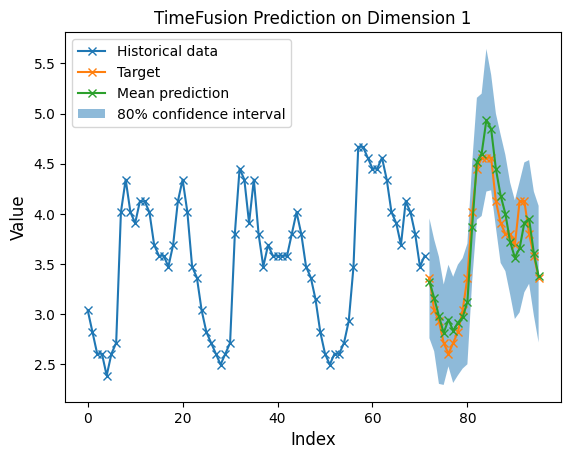

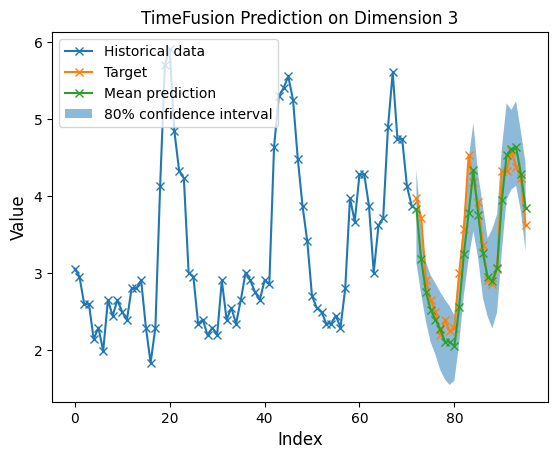

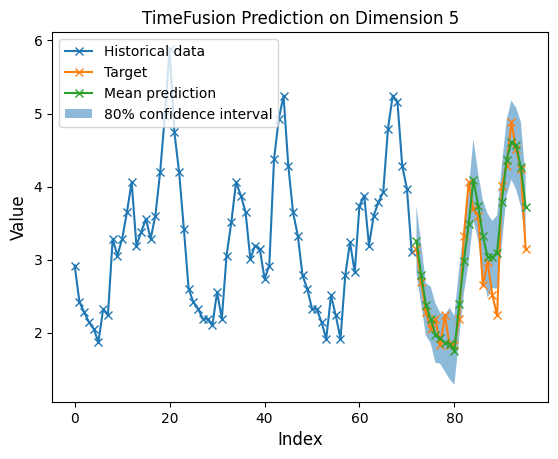

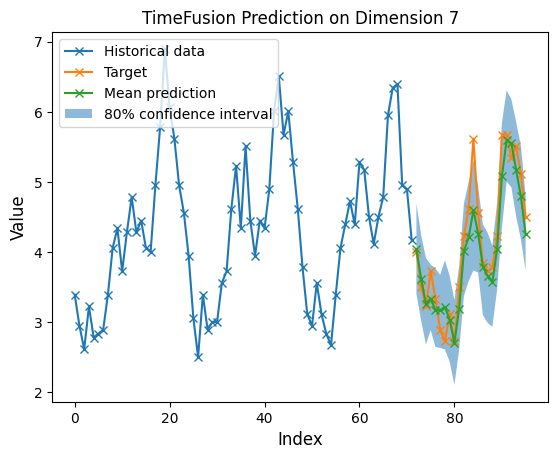

In [12]:
# Sample from model
last_idx = test_dataset.tensor_data.shape[0] - prediction_length - context_length
indices = [last_idx]
max_anchors = []
min_anchors = []
for idx in indices:
    off_idx = idx + context_length
    max_values = full_data.loc[full_data.index < test_data.index[off_idx]].max(axis=0)
    min_values = full_data.loc[full_data.index < test_data.index[off_idx]].min(axis=0)
    mean_values = full_data.loc[full_data.index < test_data.index[off_idx]].mean(axis=0)
    max_anchors.append(1.1*torch.tensor(max_values,dtype=torch.float32,device=device) - 0.1*torch.tensor(mean_values,dtype=torch.float32,device=device))
    min_anchors.append(1.1*torch.tensor(min_values,dtype=torch.float32,device=device) - 0.1*torch.tensor(mean_values,dtype=torch.float32,device=device))

max_anchors = torch.stack(max_anchors)
min_anchors = torch.stack(min_anchors)
anchors = torch.stack([min_anchors,max_anchors],dim = -1).unsqueeze(2).repeat((1,1,prediction_length,1))

samples = predictor.sample(
    data = test_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
    anchors=anchors,
    anchor_strength=0.03,
)
samples = samples.cpu()

# Sort samples in ascending order
samples = samples.permute(0,2,3,1).flatten(start_dim=0,end_dim=2).sort()[0].reshape(samples.shape[0],samples.shape[2],samples.shape[3],-1).permute(0,3,1,2)

# Plot some predictions
confidence = 0.9

for ts in [1,3,5,7]:
    plt.figure()
    plt.title(f"TimeFusion Prediction on Dimension {ts}")
    plt.plot(test_dataset.tensor_data[indices[0] - (3*prediction_length - context_length):indices[0] + context_length,ts],"-x")
    plt.plot(list(range(3*prediction_length,4*prediction_length)),test_dataset.tensor_data[indices[0] + context_length:indices[0] + context_length+prediction_length,ts],"-x")
    plt.plot(list(range(3*prediction_length,4*prediction_length)),torch.mean(samples[0,:,ts],dim = 0),"-x")
    plt.fill_between(list(range(3*prediction_length,4*prediction_length)), samples[0,int(confidence*samples.shape[1]),ts], samples[0,int((1-confidence)*samples.shape[1]),ts],alpha=0.5)
    plt.legend(["Historical data","Target","Mean prediction","80% confidence interval"],loc='upper left')
    plt.xlabel("Index",fontsize=12)
    plt.ylabel("Value",fontsize=12)
    plt.savefig(f"images/electricity_{ts}.png")
